<img style="float: left; margin: 30px 15px 15px 15px;" src="https://oci02.img.iteso.mx/Identidades-De-Instancia/ITESO/Logos%20ITESO/Logo-ITESO-Principal.jpg" width="400" height="600" /> 
    
    
#### <font color='navy'> Project. Risk Management.
    

### Objectives.

> Carry out a project that helps a committee to make an investment decision, correctly selecting for a niche of investors *x* amount of financial assets, in addition to optimize and simulate the behavior of portfolios, selecting the most appropriate strategy. Subsequently analyze the risks (market, operational and liquidity) of the selected portfolio.

### Project Definition.

The project will consist of the following seven parts, which have a specific weighting and will be defined at a later date. 

|                           | Weighting |
|---------------------------|-------------|
| 1. Asset Selection   | 20%         |
| 2 - 3. Data, Optimization and Evolution.     | 20%         |
| 4 - 5. Performance and Selection Metrics | 15%         |
| 6. Risks                 | 30%         |
| 7. Presentation          | 15%         |




In [30]:
# Import Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt

In [31]:
# Download a price on a given date
def get_historical_price(ticker: str, start: str):
    end = start+datetime.timedelta(days=4)
    price=pd.DataFrame(yf.Ticker(ticker).history(start=start, end=end)["Close"])
    return price.iloc[0, 0]

In [32]:
def get_historical_financial(t:str):
    ticker = yf.Ticker(t)
    balance = ticker.balance_sheet
    estado = ticker.income_stmt
    
    return balance, estado

## <font color = "navy"> Part 1. Asset Selection <font color = "black">

+ Select 4 to 6 publicly traded financial assets, feel free to use ETF's or stocks.  


+ Justify the selection of each of the assets with financial metrics, with Fundamental Analysis (PER, EPS, EBITDA, Beta). In this part you have to justify the selection in the best possible way, including everything we should know about the instrument, i.e. do a research about the characteristics of the companies, expectations, future plans.


### Selected Assets:
- **_`Activo 1 - EQT`_**.
- **_`Activo 2 - CFG`_**.
- **_`Activo 3 - MOS`_**.
- **_`Activo 4 - T`_**.

#  <font color = "navy">  Part 2. Data Collection <font color = "black">

+ Download from **FactSet** or **Yahoo Finance API** the adjusted closing price and volume of the selected assets.     
    
    
+ Calculate the returns of your assets with the adjusted closing price.
    

+ Present the prices, volume and returns in a DataFrame. Download them from `01-01-2021` to `today`.


**Expected Products**: Data Frame with the prices, volume and yields of the selected assets.



In [33]:
tickers = ["EQT","CFG","MOS","T"]

In [34]:
# Download the data
data = yf.download(tickers, start="2021-01-01", end="2024-02-29")

[*********************100%***********************]  4 of 4 completed


In [35]:
# Access the 'Adj Close' and 'Volume' for each ticker
adj_close = data['Adj Close']
volume = data['Volume']

KeyError: 'Adj Close'

In [ ]:
# Display the first few rows of the adjusted close prices and volume
print(adj_close.head())
print(volume.head())

In [ ]:
rends = data["Adj Close"].pct_change().dropna()
df = pd.concat([data, rends], axis=1)
df.head()

## <font color = “navy”> Part 3. Portfolio Optimization and Evolution. <font color = “black”>

+ With the returns obtained in the previous part, obtain the efficient weightings in maximum sharpe, semi-variance, omega and minimum VaR, using as optimization window from `01-01-2021` to `31-06-2023`.
    
    
+ With the weights obtained in the previous part, simulate the behavior of all the efficient portfolios (evolution of the money) for the subsequent period (`01-07-2023` to today) and plot all the evolutions within the same graph. Assume an initial capital of $1,000,000 USD.   


+ Within the graph, add the performance of a 100% passive investment strategy invested in the selected Benchmark.
    

**Expected Products**: Data Frame with optimal weightings of all methods. Two Data Frames, one with the performance of your portfolios and the other with the evolution of the value of your portfolios. Plot the evolution of portfolios.

In [ ]:
benchmark = ["^GSPC"]
benchmark=yf.download(benchmark, start="2021-01-01", end="2023-06-30")["Adj Close"]
data_stocks =yf.download(tickers, start="2021-01-01", end="2023-06-30")["Adj Close"]

rets_stocks=data_stocks.pct_change().dropna()
rets_benchmark=benchmark.pct_change().dropna()

### Máximo de Sharp

In [ ]:
def max_sharpe(rends:pd.DataFrame, rf:float, n_sims:int):
    
    expected_return=rends.mean()
    cov = rends.cov()
    n_stocks = len(rends.columns)
    w, sharpe = [], []
    
    for _ in range(n_sims):
        
        temp_w = np.random.uniform(0,1,n_stocks)
        temp_w = temp_w/np.sum(temp_w)
        
        ret= np.dot(temp_w, expected_return)
        vol=np.sqrt(temp_w.reshape(1,-1) @ cov @ temp_w)     
        
        temp_sharpe= (ret - rf)/vol
        
        w.append(temp_w)
        sharpe.append(temp_sharpe)
        
        return w[np.argmax(sharpe)] , np.max(sharpe)
      

### Semivarianza

In [ ]:
def semivar (rets_data, rets_benchmark,n):
    
    n_stocks=len(rets_data.columns)
    diffs=pd.DataFrame()
    w,sharpe = [], []
    for col in rets_data.columns:
        diffs[f'{col}_Diff Rend'] = rets_data[col] - rets_benchmark.values
            
    
    minus=diffs[diffs<0].fillna(0)
    
    downside_risk = minus.std()
    
    matriz_correlacion = rets_data.corr()
    
    value_dr = downside_risk.values

    value_dr_matriz = np.atleast_2d(value_dr)

    resultado = np.dot(value_dr_matriz.T, value_dr_matriz)
    
    m_semi = matriz_correlacion * resultado
    
    
    for _ in range(n):
         
        temp_w = np.random.uniform(0,1,n_stocks)
        temp_w = temp_w/np.sum(temp_w) 
        
        
        semiv = np.dot(m_semi, temp_w)
        final = np.dot(temp_w.T, semiv)
        
        w.append(temp_w)
        sharpe.append(final)
        
        return w[np.argmin(sharpe)] , np.min(sharpe)


### Omega

In [ ]:
def omega (rets_data, rets_benchmark,n):
    
    n_stocks=len(rets_data.columns)
    diffs=pd.DataFrame()
    w,om = [], []
    for col in rets_data.columns:
        diffs[f'{col}_Diff Rend'] = rets_data[col] - rets_benchmark.values
            
    
    minus=diffs[diffs<0].fillna(0)
    upper=diffs[diffs>0].fillna(0)
    
    downside_risk = minus.std()
    upside_risk = upper.std()
    
    omega = upside_risk/downside_risk
    
    for _ in range(n):
    
        temp_w = np.random.uniform(0,1,n_stocks)
        temp_w = temp_w/np.sum(temp_w) 

        omega_final = omega.T @ temp_w
        
        w.append(temp_w)
        om.append(omega_final)
    
    return  w[np.argmax(om)] , np.max(om)

### Min VaR

In [ ]:
def min_var(rets_data, rets_benchmark, conf, n):
    
    n_stocks=len(rets_data.columns)
    diffs=pd.DataFrame()
    w, variances = [], []
    for col in rets_data.columns:
        diffs[f'{col}_Diff Rend'] = rets_data[col] - rets_benchmark.values    
    
    for _ in range(n):
        temp_w = np.random.uniform(0, 1, n_stocks)
        temp_w /= np.sum(temp_w)

        var = np.percentile(rets_data,100-conf*100)

        w.append(temp_w)
        variances.append(var)

    min_var_index = np.argmin(variances)
    min_var_portfolio = w[min_var_index]

    return min_var_portfolio, variances[min_var_index]

In [ ]:
optimal_sharpe_weights = max_sharpe(rets_stocks, 0.05/252, 10000) [0]
w_semivar = semivar(rets_stocks, rets_benchmark,100000)[0]
w_omega = omega(rets_stocks, rets_benchmark,10000)[0]
pesos_min_var = min_var(rets_stocks,rets_benchmark,0.99,10000)[0]

In [ ]:
optimal_sharpe_weights = [0.351639,0.142512, 0.037133, 0.468716]
w_semivar = [0.403434,0.211918,0.004712,0.379936]
w_omega = [0.081467, 0.027836, 0.874609,0.016088]
pesos_min_var = [0.448649, 0.040244, 0.464946,0.046161] 

### Optimal method weights

In [ ]:
df_weights = pd.DataFrame({
    'Sharp': optimal_sharpe_weights,
    'Semivar': w_semivar,
    'Omega': w_omega,
    'Min Var': pesos_min_var
})
df_weights

In [ ]:
benchmark = "^GSPC"
df_filtrado = df.loc[df.index > '2023-07-01']
df_rts = df_filtrado.iloc[:,-len(tickers):]
ret_bench=yf.download(benchmark, start='2023-07-01', end="2024-02-29")["Adj Close"]
ret_bench=ret_bench.pct_change().fillna(0)
df_bench = pd.DataFrame(ret_bench)

In [ ]:
cap_inicial = 1000000
port_value = [cap_inicial]
port_rets = [0]
n = len(df_rts)
weights = [optimal_sharpe_weights,w_semivar, w_omega,pesos_min_var]
names = ["Radio Sharpe", "Semivar", "Omega", "Min VaR"]
num_ports = len(weights)

In [ ]:
df_portfolios = pd.DataFrame(index=df_rts.index)

for names, w in zip(names, weights):
    port_rets = [0]
    port_value = [cap_inicial]
      
    for j in range(1, n):
        prev_port_val = port_value[j-1]
        port_ret = np.sum(w * df_rts.iloc[j])
        portfolio_value_i = prev_port_val * (1 + port_ret)

        port_rets.append(port_ret)
        port_value.append(portfolio_value_i)

    df_portfolios[f'Returns_{names}'] = port_rets
    df_portfolios[f'Portfolio_Value_{names}'] = port_value

df_portfolios.tail(3)

In [ ]:
n_bench= len(ret_bench)
cap_inicial = 1000000
port_value = [cap_inicial]
port_rets = [0]
for i in range (1,n_bench):
    prev_port_val = port_value[i-1]
    port_ret = np.sum(1 * df_bench.iloc[i])
    
    portfolio_value_i = prev_port_val * (1 + port_ret)

    port_rets.append(port_ret)
    port_value.append(portfolio_value_i)
    
df_port_bench = pd.DataFrame({'Returns': port_rets, 'Portfolio_Value_Benchmark': port_value}, index=df_rts.index)
#df_port_bench

### Portfolio Graphics

In [ ]:
df_portfolios = pd.concat([df_portfolios, df_port_bench], axis=1)

In [ ]:
df_portfolios.tail()

In [ ]:
plt.figure(figsize=(10, 6))
ax = plt.subplot()

for col in df_portfolios.columns:
    if 'Portfolio_Value' in col: 
        ax.plot(df_portfolios.index.to_numpy(), df_portfolios[col].to_numpy(), label=col)

ax.set_xlabel('Fecha')
ax.set_ylabel('Valor del Portafolio')
ax.set_title('Portafolios a lo largo del tiempo')
plt.grid(True, linestyle='--', linewidth=0.25, color='black')
ax.legend()

plt.show()

## <font color = “navy”> Part 4. Performance Metrics. <font color = “black”>

+ Assemble a data frame showing the following metrics for all portfolios: Annualized Return, Annualized Volatility, Sharpe Ratio, Beta, Jensen's Alpha, and Sortino's Ratio.    
    
    Annualized Return** **Annualized Return** **Annualized Volatility** **Sharpe Ratio
    * Annualized Volatility
    * Sharpe Ratio
    ** **Sharpe Ratio** * **Beta**
    * Jensen's Alpha
    * Sortino's Ratio.        
    
    
+ Comment on the *insights* found in the ratios, what do the obtained results mean.     
    
  
**Expected Deliverables**: Data Frame with Performance Metrics and comment on the results.

In [ ]:
# Annualized Profit and Volatility
medias_returns = []
vol_ = []
for col  in df_portfolios.columns:
    if "Returns" in col:
        rend = df_portfolios[col].mean()*252
        vol = df_portfolios[col].std()*252**0.5
        
        
        vol_.append((col, vol))
        medias_returns.append((col, rend))

In [ ]:
# Sharpe Ratio
tlr = 0.05/252 # Risk Free Rate
medias_returns_dict = dict(medias_returns)
vol_returns_dict = dict(vol_)
medias_returns = pd.Series(medias_returns_dict)
vol_d = pd.Series(vol_returns_dict)
ratio = (medias_returns - tlr) / vol_d

In [ ]:
# Beta
beta_ = []
for col_name in df_portfolios.columns:
    if "Returns" in col_name:
        
        col = df_portfolios[col_name]
        col_array = col.to_numpy()
        ret_bench_array = ret_bench.to_numpy()
        
        covariance = np.cov(col_array, ret_bench_array)[0][1]
        variance_market = np.var(ret_bench_array)
        
        beta = covariance / variance_market
        
        beta_.append((col_name, beta))

In [ ]:
# Jensen's Measure (Alpha)


In [ ]:
# Ratio Sortino

In [ ]:
medias_returns_dict = dict(medias_returns)
vol_dict = dict(vol_)
beta_dict = dict(beta_)
ratio = dict(ratio)

df_medias_returns = pd.DataFrame(medias_returns_dict.values(), index=medias_returns_dict.keys(), columns=['Rendimiento Anualizado'])
df_vol = pd.DataFrame(vol_dict.values(), index=vol_dict.keys(), columns=['Volatilidad Anualizada'])
df_beta = pd.DataFrame(beta_dict.values(), index=beta_dict.keys(), columns=['Beta'])
df_ratio = pd.DataFrame(ratio.values(), index=ratio.keys(), columns=['Ratio Sharp'])

df_combined = pd.concat([df_medias_returns, df_vol,df_beta, df_ratio], axis=1)

nuevos_nombres = {'Returns_Radio Sharpe': 'Portafolio Sharp', 
                  'Returns_Semivar': 'Portafolio Semivar', 
                  'Returns_Omega': 'Porfafolio Omega', 
                  'Returns_Min VaR': 'Portafolio Min Var'}

df_combined.rename(index=nuevos_nombres, inplace=True)

df_combined


## Part 5. Selection of the Best Portfolio <font color = “black”> <font color = “black”>

+ Based on what was discussed in section number one and the previous section. Select the “*best portfolio*” according to the investment horizon, investor profile and economic situation.    
       
    
  
**Expected Products**: Selection of the best portfolio. Graph of the selected strategy against benchmark. 

#### <font color = “green”> - Best Portfolio: SemiVar

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_portfolios['Portfolio_Value_Semivar'], label=' Port Semivar')
plt.plot(df_portfolios['Portfolio_Value_Benchmark'], label='Benchmark')
plt.xlabel('Fechas')
plt.ylabel('Valores')
plt.title('Mejor portafolio vs Benchmark')
plt.grid(True, linestyle='--', linewidth=0.25, color='black')
plt.legend()
plt.show()

##  <font color = "navy">  Part 6. Risk. <font color = "black">


+ For the portfolio selected in the previous part, calculate the VaR and the one-day ES with 99% confidence of your portfolio for the whole simulation period. Analyze the whole data series and conclude about it.  

In [ ]:
conf = 0.99
port_returns=df_portfolios["Returns_Semivar"]
var = np.percentile(port_returns, (1 - conf)*100)
es = np.mean(port_returns[port_returns < var])
print("El VaR al 99% es:", np.round(var,5))
print("El ES al 99% es:", np.round(es,6))

**Respond based on the average volume of each asset over the last 3 months, how many days would it take you to unwind your position in each asset if you sold your entire portfolio?** ** **Respond based on the average volume of each asset over the last 3 months, how many days would it take you to unwind your position in each asset if you sold your entire portfolio?  


+ Calculate the VaR in cash and answer: If your VaR limit is 10% of the value of your portfolio, as a portfolio manager, what would you do to meet the VaR limit, if you are exceeding it or in the future will exceed it? Propose a specific and clear strategy.      

In [ ]:
port_val = df_portfolios['Portfolio_Value_Semivar'].iloc[-1]
var_cash = var*port_val
var_cash

    
+ Show the correlation matrix of the assets in your portfolio and conclude about the risks and/or benefits you have with the diversification of your portfolio.  
    

In [ ]:
rets_data = df_rts* w_semivar
matriz_correlacion = rets_data.corr()
matriz_correlacion

##  <font color = "navy">  Part 7. Presentation. <font color = "black">


Asset Selection


The asset selection methodology was based on the value investing theory, using six parameters, Price to Book, Price to Earnings, Net Margin, Cash Flow / Sales, Debt to Equity and Return on Equity, giving emphasis from highest to lowest in the order mentioned, these metrics were applied to the SP 500 companies, classified by sector and all financial ratios were compared with the same sector.

Subsequently, the three best companies in each sector were selected according to their undervaluation by market value versus book or book value. It is sought that most of the metrics have a better performance than their respective peers or otherwise find out why it does not happen and the expectations or possible scenarios for that asset. From the sample of 500 companies, according to the aforementioned criteria the following 4 assets were chosen.

Image: Results of selected assets, metrics and comparatives.



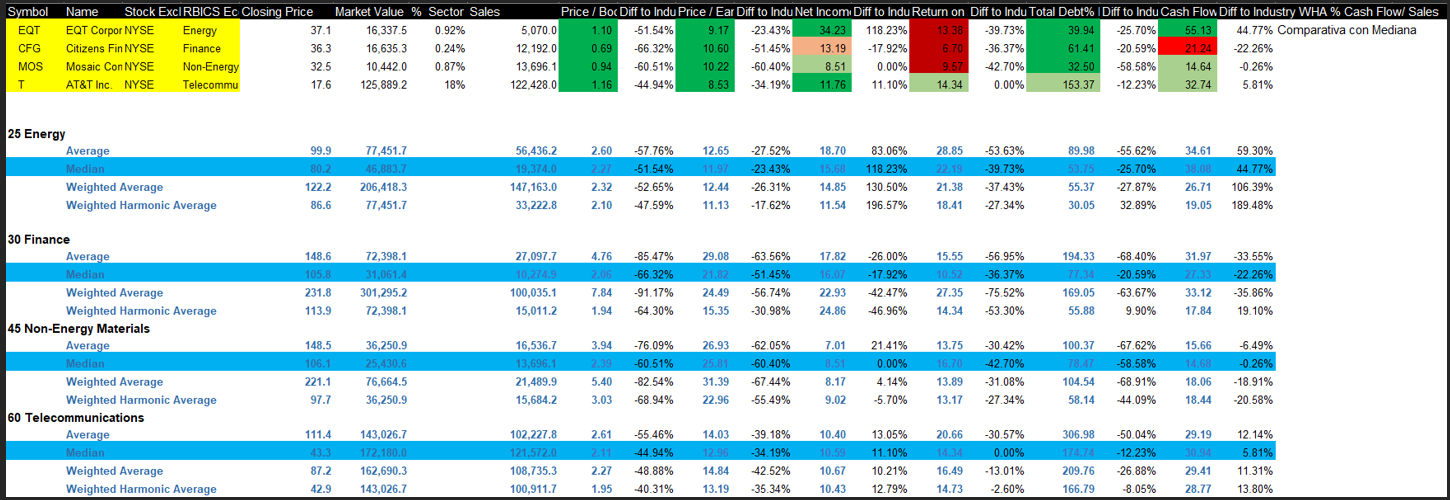

## <font color = "navy">  Part 1a. Asset Selection Explanation. <font color = "black">

##  <font color = "blue"> EQT Corporation.
EQT Corporation is the largest natural gas producer in the United States. It is a leading independent natural gas producer and is engaged in hydrocarbon exploration and pipeline transportation. It is headquartered in EQT Plaza in Pittsburgh, Pennsylvania.

It belongs to the energy sector and was selected due to its PB of 1.10, 52% below the sector median, as well as its P/E of 9.17, 23% below its peers. Also, in terms of financial capacity, it has net profit margins of 34%, 118% higher than the industry, a return on equity of 13%, which is lower by 40%, a debt equity ratio of 40%, 33% lower, and finally, a net income margin of 34%, 118% higher than that of the industry, a return on equity of 13%, which is lower by 40%.  
 33% below and finally a cash flow to sales ratio of 55%, which is 45% above the industry. In summary, EQT is a leading company in the energy sector, specifically natural gas, which has excellent valuation ratios and is undervalued by the market. It is a company that generates profits. It generates cash flows. It is profitable and does not have a high level of leverage.

EQT Corporation Strategy:
Vision: To become the world leader in the production of liquefied natural gas (LNG) and chemical products.

Mission: To responsibly develop, produce and market EQT Corporation's natural resources to create value for its shareholders and society.

Strategic plans:

Increase LNG production: EQT Corporation plans to increase its LNG production from 33 million tons per year (mtpa) in 2023 to 50 mtpa in 2027. This will be achieved by expanding its operations in the United States and developing new projects in other countries.

Diversify its product portfolio: EQT Corporation also plans to diversify its product portfolio to include more chemicals. This will be achieved by investing in chemical development projects and acquiring chemical companies.

Reduce its environmental footprint: EQT Corporation is committed to reducing its environmental footprint. This will be achieved by investing in carbon capture and storage (CCS) and other environmental technologies.

Numbers:

LNG production: In 2023, EQT Corporation produced 33 mtpa of LNG. The company plans to increase its production to 50 mtpa in 2027.

Revenues: In 2023, EQT Corporation generated $27 billion in revenues. The company expects its revenues to increase to $40 billion in 2027.

Net earnings: In 2023, EQT Corporation generated $4 billion in net earnings. The company expects its net earnings to increase to $6 billion in 2027.
Environmental footprint: In 2023, EQT Corporation emitted 10 million tons of carbon dioxide (CO2). The company is committed to reducing its CO2 emissions to 5 million tons by 2027.

Additional resources:

EQT Corporation website: https://www.eqt.com/ 
EQT Corporation 2023 Annual Report: https://eqtgroup.com/news/reports/ 

Overview

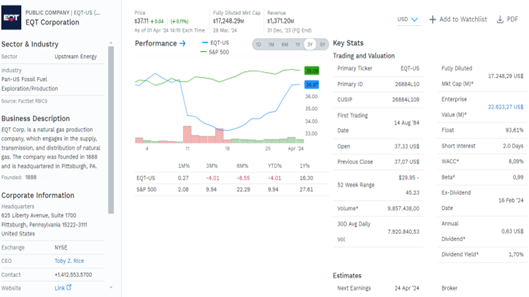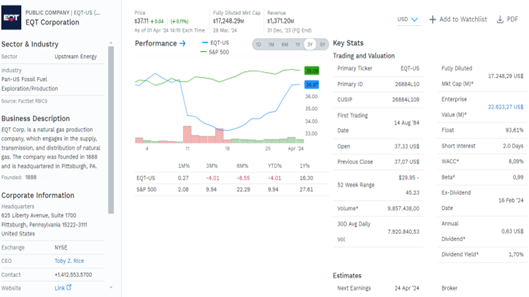



Yahoo Finance Analysts Estimate
    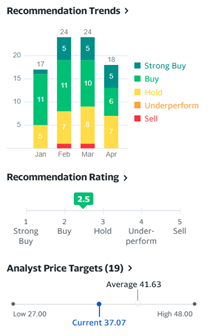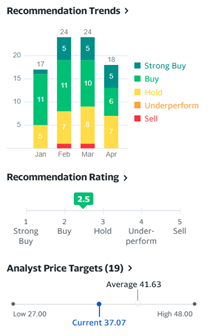 

Factset Analysts Estimate
    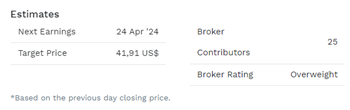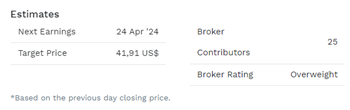 


Analysts' estimate supports our asset selection decision, with an estimated target price upside of approximately 11%.

Future plans: 
EQT Corp has signed an agreement to buy back its former Equitrans Midstream unit in a deal worth about 5.5 billion in which all shares will be combined, this acquisition seeks to make the first vertically integrated natural gas company, according to its most recent investor relations release (March 11) this synergy is founded on: Unmatched integrated cost structure, drives durable free cash flow generation, transforms the quality of an already category-leading inventory, high free cash flow margins strengthen credit quality, increased short and long-term shareholder financials, low cost structure limits hedging needs, unlocking upside potential, thus creating identified synergies greater than $425 million annually.

Additional resources: https://ir.eqt.com/investor-relations/overview/default.aspx 


##  <font color = "blue"> CFG

Citizens Financial Group, Inc. offers a full range of commercial banking services. The bank offers consumer loans, commercial loans, mortgage loans, deposit products, Internet banking and trust services. Citizens Financial Group serves customers in the United States.

It belongs to the Finance sector. Comparing the sector with the median of the data, in terms of valuation ratios it is largely undervalued with .69 PB which is 66% lower than its peers. In Price vs. Earnings it is valued at 10.6, which is 51% lower than the sector. Its operation generates a net profitability of 13.19%, which is 18% below, however it is still in contact with a healthy and positive net margin sufficient to generate profitability for investors. In terms of return on equity it has 6.7% which implies 36% less, mentioning the level of leverage, according to the debt equity ratio the company when with 61% which is 21% lower than the industry, and finally its cash flow against sales is 21.24% which is 22% lower than its peers. Despite having three metrics that are not the best in its sector. It is assumed that being a company with low leverage, if it chooses to increase it, it would be able to generate this differential in cash flows, earnings and yields.

As for CFG's future plans, in his latest Q4 2023 press release Bruce Van Saun, CEO, did not comment on strategies or concrete plans for the bank, he only mentions and details the balance sheet and income statement report, the specific financials of capital plans, which describe strategies for dividends, share repurchases and maintenance of capital reserves. These are positive and maintain Tier 1 liquidity and credit risk improvement, among other data. It is an industry that has undergone many changes and uncertainty in recent years, but in the long term we believe that due to its listing conditions, evaluation and financial soundness it will not be a problem for Citizens Group.
 
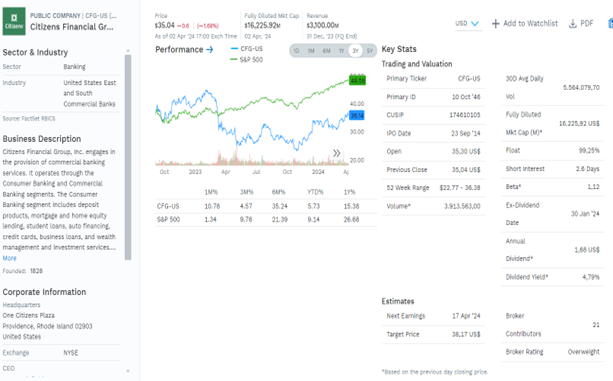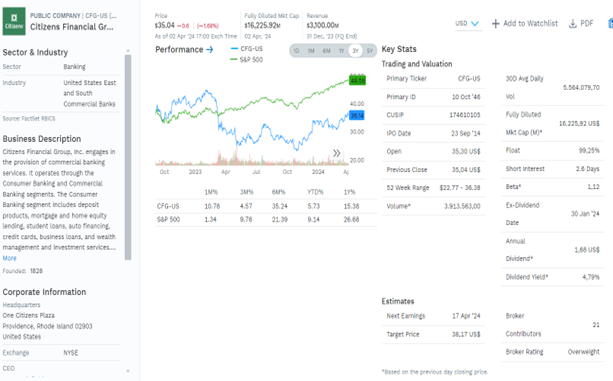 
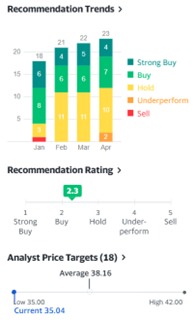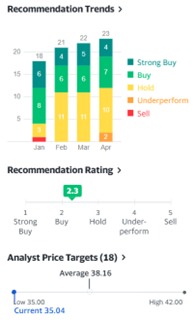

According to analysts from both Factset and Yahoo Finance data, the target price is 38.17, 9% above the current price, recommending an Overweight. 
This together with our sector comparative analysis and strategy based on Value Investing metrics supports the selection decision.


##  <font color = "blue"> MOS
Mosaic Company is a world leader in the crop nutrient sector, the only company capable of producing and supplying on a large scale two vital crop nutrients: phosphate and potash. Mosaic is involved in all phases of crop nutrition, from resource extraction to the production of crop nutrients, feed and industrial products for customers around the world.

It belongs to the non-energy materials sector, specifically the agricultural fertilizer industry. It trades at a market price to book of .94, 61% lower than its peers in terms of price to earnings at 10.22 which is 60% lower, its net margin is 8.51% so it is on par with the sector median, its 9.57% return on equity is 43% lower than the competition. Its leverage level of 32.5% indicates that the company is not leveraged and in fact is 59% below the median. Finally, the flows generated by its operation against income are 15%, which also places it in the median of the data.

Like the CFG asset this 60% of lower leverage. It is a company that is quite undervalued and has attractive expansion plans.


Mosaic Company's strategic plans
1. Growth through capacity expansion:

Invest in expansion of existing potash mines at Esterhazy and K3 in Canada.
Develop the Fort Meade phosphate mine in Florida.
Expand phosphoric acid production capacity in Brazil.
2. Focus on efficiency and productivity:

Implement continuous improvement initiatives in all operations.
Optimize the supply chain.
Reduce production costs.

3. New product and market development:

Invest in research and development to create new products and solutions.
Expand into new emerging markets.
Develop new distribution channels.


Mosaic Company website: https://www.mosaicco.com/ 
Mosaic Company Annual Report: https://investors.mosaicco.com/financials/annual-reports/default.aspx 
Mosaic Company investor presentations: https://investors.mosaicco.com/events-and-presentations/default.aspx

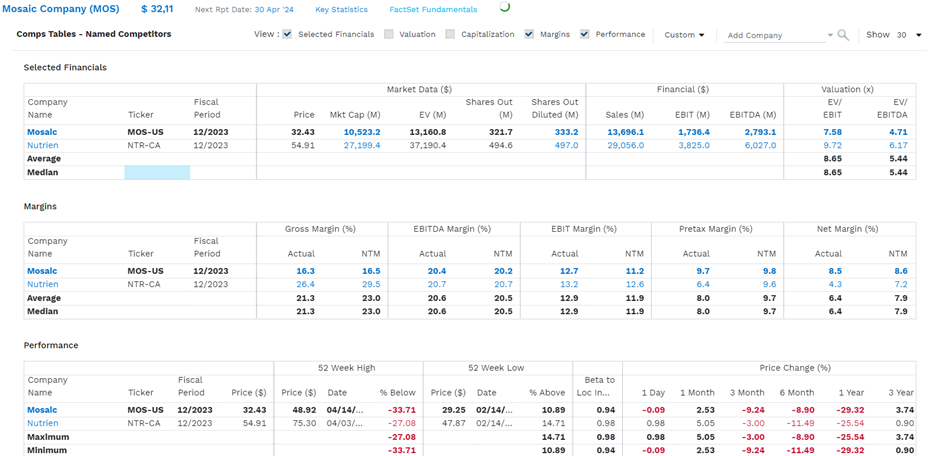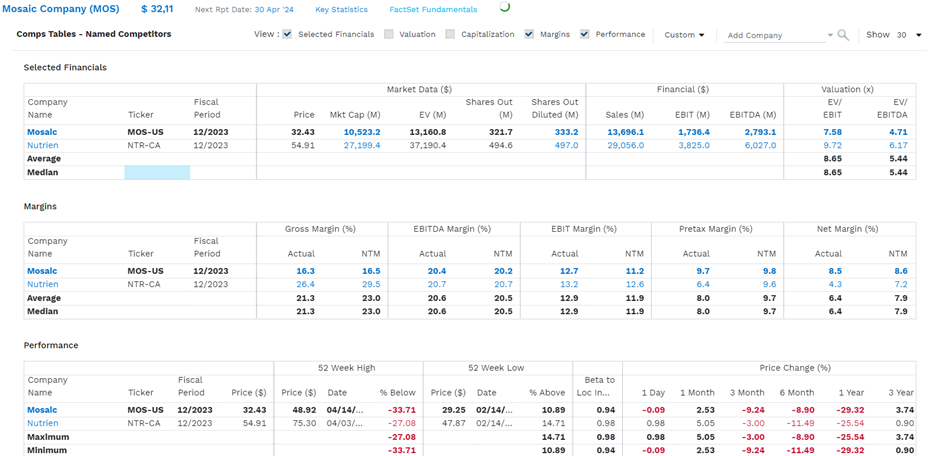

 

As for a more precise comparison of Mosaic's direct competition in North America, from the point of view of valuation, stock performance and margins, we can see that the selected company, despite being a third of the market cap and EV of its most relevant competitor, really has the tools that support an advantage and better conditions in general.

As for the opinion of professionals, the recommendation or pattern is between hold and buy, with an average target price of 37.56, almost 17% above the current market price.
 
 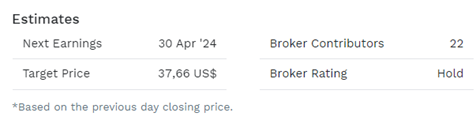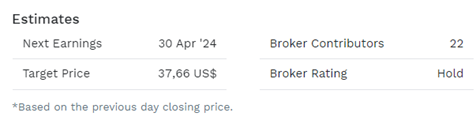
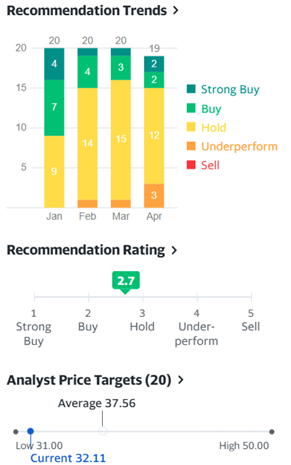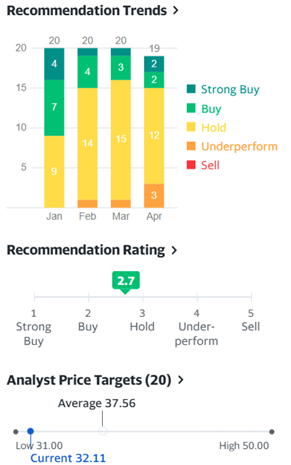


##  <font color = "blue"> T
 

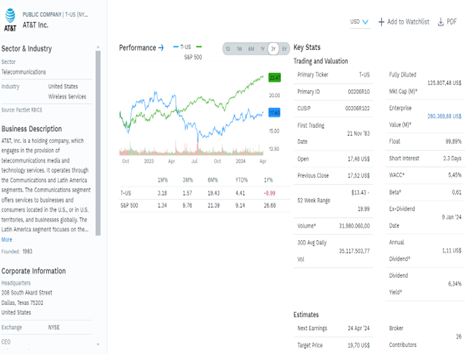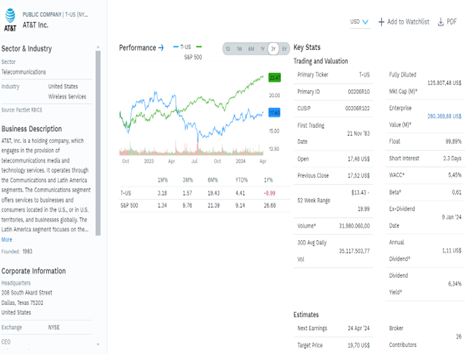


AT&T Inc. operates as a communications holding company. The company, through its subsidiaries and affiliates, provides local and long distance telephone services, wireless and data communications, Internet access and messaging, satellite and IP-based television, telecommunications equipment, and advertising and directory publishing services.

It belongs to the telecommunications sector, and is also a leader in it, having a weight of 18% of the companies in the same sector that belong to the SP500, it is valued at 1.16, which favors it by being 45% lower than the competition its P/E of 8.53 is 34% less than the sector. Net margin is 11.76% 11% higher than the others, Return on equity is in line with the median at 14.34% its leverage level is at 153%, which is 12% lower than its peers and finally cash generation capacity against sales is 32.74% 6% higher than the competition. Despite being the most important player in terms of size, sales and assets, we find that it is an undervalued company, for valuation reasons, it is able to generate earnings and cash above the sector, a company that despite being leveraged putting it in context with its peers has room for growth in terms of debt.

Telecommunications companies, especially in the U.S. market, have suffered in the last year from news that has severely affected public opinion, although it is a complicated challenge it also presents an opportune moment of entry for new investors at prices below their real value.

Communications service providers have large cost burdens and increased responsibilities to deliver reliable connectivity and quality of service. In 2024, their investments may struggle to pay off, and the businesses they once dominated will likely face strong competition from multiple sectors, especially in home broadband. However, they may also have the opportunity to redefine their position in the connectivity ecosystem and strengthen their future position. We believe there is a high opportunity for the Generative AI industry and the competitor that is most able to use this type of technology to its advantage and gain the already damaged consumer and investor confidence. 
  

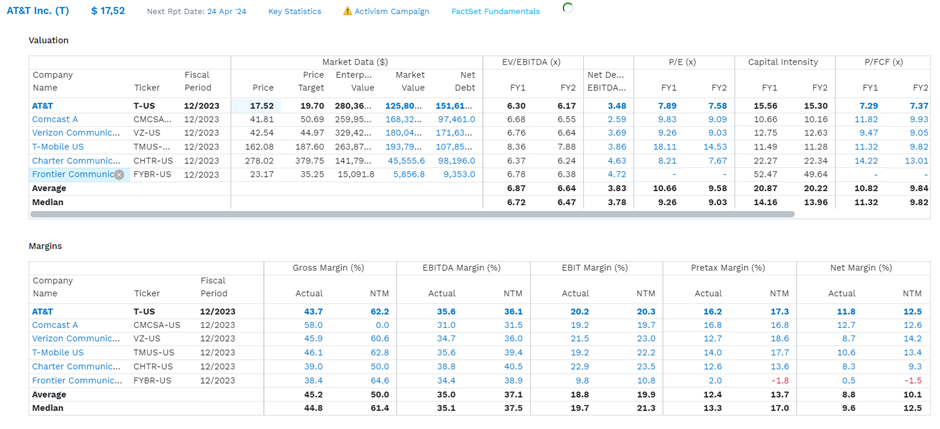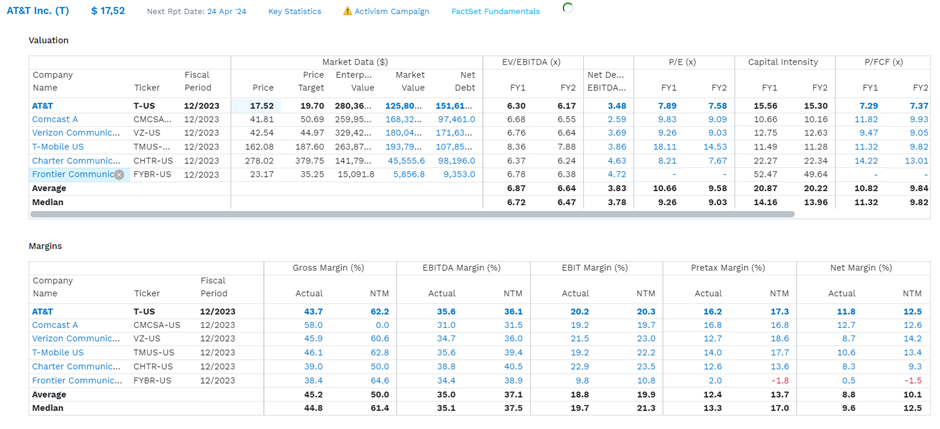
 
 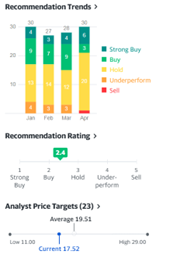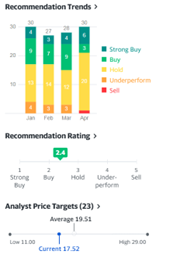

We can see that AT&T is priced below its comparative value to its strongest competitors, relative to both its ability to generate revenue (EBITDA) and cash (FCF), with superior profitability margins. A volatility of .66, with a target price of 19.77 according to the estimates of 26 brokers reporting on Factset, recommending an overweight stock. Taking into account the Yahoo Finance data we observe that the target price is very similar and is almost 12% above the current one, recommending to buy the asset, these estimates give further support to our investment selection decision and reinforce our analysis.








